In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
import xgboost as xgb
from sklearn import metrics, preprocessing
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
import warnings

warnings.filterwarnings("ignore")

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [3]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
#intuit75k.head()

In [4]:
intuit75k = intuit75k.assign(
    zip801=(intuit75k["zip"] == "00801").astype(int),
    zip804=(intuit75k["zip"] == "00804").astype(int),
)

In [5]:
rvar = "res1_yes"
var = [
    "zip_bins",
    "sex",
    "bizflag",
    "version1",
    "owntaxprod",
    "upgraded",
    "zip801",
    "zip804",
]
std_evars = [
    "numords",
    "dollars",
    "last",
    "sincepurch",
]

avar = [
    "zip_bins",
    "sex",
    "bizflag",
    "version1",
    "owntaxprod",
    "upgraded",
    "zip801",
    "zip804",
    "numords",
    "dollars",
    "last",
    "sincepurch",
]
evar = [
    "zip_bins",
    "bizflag",
    "version1",
    "owntaxprod",
    "upgraded",
    "zip801",
    "zip804",
    "numords",
    "dollars",
    "last",
    "sincepurch",
    "Female",
    "Male",
    "Unknown",
]

idvar = "id"
lev = 1

In [6]:
train = intuit75k.loc[intuit75k["training"] == 1]
test = intuit75k.loc[intuit75k["training"] == 0]
eval_dat = pd.concat([train, test], axis=0)
eval_dat = eval_dat[[idvar, rvar, "training"]]
X_train = train[avar]
y_train = train[rvar]
X_test = test[avar]
y_test = test[rvar]

In [7]:
X_train[["Female", "Male", "Unknown"]] = pd.get_dummies(
    X_train["sex"], drop_first=False
)
X_train = X_train.drop(["sex"], axis=1)
X_test[["Female", "Male", "Unknown"]] = pd.get_dummies(X_test["sex"], drop_first=False)
X_test = X_test.drop(["sex"], axis=1)

# XGBOOST

In [8]:
# combining so we can predict for the full dataset as well
Xs = np.concatenate((X_train, X_test), axis=0)

In [9]:
clf = xgb.XGBClassifier(
    min_child_weight=5,
    colsample_bylevel=1,
    max_delta_step=0,
    scale_pos_weight=1,
    alpha=1,
    reg_lambda=0,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=1,
    gamma=1,
    max_depth=3,
    n_estimators=500,
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="auc",
    random_state=1234,
).fit(X_train, y_train.values, verbose=True)

In [10]:
# predict for the entire dataset
eval_dat["y_xgb"] = clf.predict_proba(Xs)[:, 1]

In [11]:
pred_train = clf.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, pred_train[:,1])

pred_test = clf.predict_proba(X_test)
fpr_t, tpr_t, thresholds_t = metrics.roc_curve(y_test, pred_test[:,1])

print(f"AUC training data for model: {metrics.auc(fpr, tpr)}")
print(f"AUC test data for model: {metrics.auc(fpr_t, tpr_t)}")

AUC training data for model: 0.7773267812281904
AUC test data for model: 0.7649020750953851


In [12]:
def w2_profit(resp):
    # calculating the profit for wave-2 on test set
    breakeven = 1.41 / 60
    wave2_target = 763334
    eval_dat['mod_resp'] = eval_dat[resp] * 0.5
    eval_dat['mod_mail'] = eval_dat['mod_resp'] > breakeven
    df = eval_dat[eval_dat['training']==0]
    
    mail_true= sum(df['mod_mail']) #num of yes in test set
    mail_true_rate = mail_true / df.shape[0] #proportion to yes is test set
    buy_true = df[(df['mod_mail']==True) & (df['res1_yes']==1)] #true positives
    
    mail_number = wave2_target * mail_true_rate #customers to mail
    adjusted_rr = (buy_true.shape[0] * 0.5) / mail_true #adjusted buy rate
    wave2_buyers = adjusted_rr * mail_number #buyers in wave 2
   
    mail_cost = 1.41 * mail_number 
    profit = 60 * wave2_buyers - mail_cost
    rome = profit / mail_cost
    
    return profit,rome

In [13]:
# function for the lifts and gains plot
def plot(resp):
    # lift and gains plot
    w = 13
    h = 4
    d = 100
    fig = plt.figure(figsize=(w, h), dpi=d)
    fig.suptitle(f"Cumulative Lift and Gains For XGBoost Model")

    fig1 = fig.add_subplot(122)
    fig1.set_title("Cumulative Gains")
    fig1 = rsm.gains_plot(
        {
            "Training": eval_dat.query("training == 1"),
            "Test": eval_dat.query("training == 0"),
        },
        rvar="res1_yes",
        pred=resp,
        lev=1,
        qnt=10,
    )

    fig2 = fig.add_subplot(121)
    fig2.set_title("Cumulative Lift")
    fig2 = rsm.lift_plot(
        {
            "Training": eval_dat.query("training == 1"),
            "Test": eval_dat.query("training == 0"),
        },
        rvar="res1_yes",
        pred=resp,
        lev=1,
        qnt=10,
    )

Wave-2 Scaled Campaign: The Profit is $452,060 and the the return on investment is 131.47% 



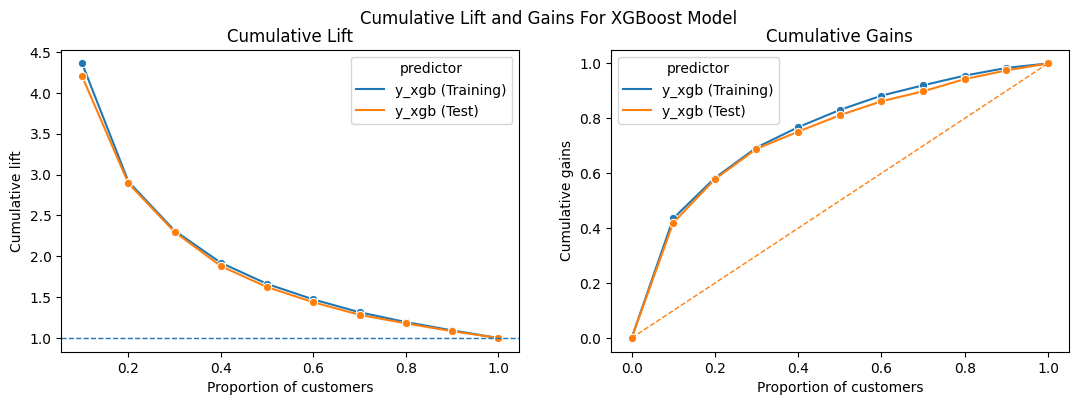

In [14]:
plot("y_xgb")
scaled_prof, scaled_rome = w2_profit("y_xgb")

print(
    f"""Wave-2 Scaled Campaign: The Profit is ${int(scaled_prof):,} and the the return on investment is {round(float(scaled_rome)*100,2):,}% \n"""
)

In [15]:
print(
    f""" The output above is the result of an XGBoost model with the hyperparameters set to:
    min_child_weight=5,
    colsample_bylevel=1,
    max_delta_step=0,
    scale_pos_weight=1,
    alpha=1,
    reg_lambda=0,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=1,
    gamma=1,
    max_depth=3,
    n_estimators=500 """
)

 The output above is the result of an XGBoost model with the hyperparameters set to:
    min_child_weight=5,
    colsample_bylevel=1,
    max_delta_step=0,
    scale_pos_weight=1,
    alpha=1,
    reg_lambda=0,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=1,
    gamma=1,
    max_depth=3,
    n_estimators=500 


In [16]:
print(
    f""" The graphs above show the cumulative lift and gains for the XGBoost model predicted on both the training and test datasets. And plots and the AUC indicate a low overfitting, if any.\n  """
)

 

 The graphs above show the cumulative lift and gains for the XGBoost model predicted on both the training and test datasets. And plots and the AUC indicate a low overfitting, if any.
  


XGBoost Cross Validated Model

In [17]:
# clf = xgb.XGBClassifier()
# param_grid = {
# "colsample_bytree": [0.3, 0.7],
# "n_estimators": [500],
# "min_child_weight": list(range(0,10)),
# "max_depth": [3,4,5,6]
# }
# scoring = {"AUC": "roc_auc"}

In [18]:
# clf_cv = GridSearchCV(
# clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
# ).fit(X_train, y_train)

In [19]:
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

In [20]:
# predict for the entire dataset
# eval_dat["y_xgb_cv"] = clf_cv.best_estimator_.predict_proba(Xs)[:, 1]

In [21]:
# Profit, Cumulative lift and gains for XGBoost Cross Validated Model

In [22]:
# reg_prof, reg_rome, scaled_prof, scaled_rome = w2_profit("y_xgb_cv")

# print(
# f"""Wave-2 Campaign: The Profit is ${int(reg_prof):,} and the the return on investment is {round(float(reg_rome)*100,2):,}% """
# )

# print(
# f"""Wave-2 Scaled Campaign: The Profit is ${int(scaled_prof):,} and the the return on investment is {round(float(scaled_rome)*100,2):,}% """
# )

In [23]:
# plot("y_xgb")

In [24]:
eval_dat.to_csv("./data/XGB.csv", index=False)